In [1]:
%pip install -r requirements.txt
import pandas as pd
import numpy as np
import xgboost as xgb
import os
import tarfile
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

Note: you may need to restart the kernel to use updated packages.


In [28]:
folder_path = "data"
# folder_path = "data_small"

In [29]:
def unarchive_and_read_tsv(prefix, tsv_filename):
    file_to_unarchive = None
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tar.gz') and file_name.startswith(prefix):
            file_to_unarchive = os.path.join(folder_path, file_name)
            break

    if file_to_unarchive is None:
        print(f"No matching .tar.gz file found with prefix '{prefix}'.")
        return None

    archive_name = os.path.basename(file_to_unarchive)[:-7]
    unarchived_folder = os.path.join(folder_path, archive_name)
    if os.path.exists(unarchived_folder):
        print("File already unarchived.")
    else:
        with tarfile.open(file_to_unarchive, 'r:gz') as tar:
            tar.extractall(unarchived_folder)
        print("File unarchived successfully.")

    tsv_file = os.path.join(unarchived_folder, tsv_filename)
    dataframe = pd.read_csv(tsv_file, delimiter='\t')
    return dataframe


In [67]:
prefix = "clinical"
tsv_filename = "clinical.tsv"

clinical_df = unarchive_and_read_tsv(prefix, tsv_filename)
print(clinical_df)

File already unarchived.
                                   case_id case_submitter_id project_id   
0     001ad307-4ad3-4f1d-b2fc-efc032871c7e      TCGA-HT-A614   TCGA-LGG  \
1     001ad307-4ad3-4f1d-b2fc-efc032871c7e      TCGA-HT-A614   TCGA-LGG   
2     0061e9ef-df6a-414e-af64-c88f8192e2d3      TCGA-E1-5311   TCGA-LGG   
3     0061e9ef-df6a-414e-af64-c88f8192e2d3      TCGA-E1-5311   TCGA-LGG   
4     0073a136-d5f4-4fd6-88f9-711768f2abc6      TCGA-VM-A8CF   TCGA-LGG   
...                                    ...               ...        ...   
1726  fee2114e-f723-4374-91f8-f1dcc6b3eaee      TCGA-HT-7470   TCGA-LGG   
1727  ffcec8e5-9fd3-4b42-a7cb-74761f713cf4      TCGA-HT-7606   TCGA-LGG   
1728  ffcec8e5-9fd3-4b42-a7cb-74761f713cf4      TCGA-HT-7606   TCGA-LGG   
1729  fff304a2-113f-499d-a88c-9d3660c348d9      TCGA-RY-A847   TCGA-LGG   
1730  fff304a2-113f-499d-a88c-9d3660c348d9      TCGA-RY-A847   TCGA-LGG   

     age_at_index age_is_obfuscated cause_of_death cause_of_death_source  

In [68]:
# Remove duplicate rows based on 'case_submitter_id' column
print(f'Shape before deduplication: {clinical_df.shape}')
clinical_df = clinical_df.drop_duplicates(subset='case_submitter_id', keep='first')
print(f'Shape after deduplication: {clinical_df.shape}')

print(clinical_df.head())

Shape before deduplication: (1731, 158)
Shape after deduplication: (822, 158)
                                case_id case_submitter_id project_id   
0  001ad307-4ad3-4f1d-b2fc-efc032871c7e      TCGA-HT-A614   TCGA-LGG  \
2  0061e9ef-df6a-414e-af64-c88f8192e2d3      TCGA-E1-5311   TCGA-LGG   
4  0073a136-d5f4-4fd6-88f9-711768f2abc6      TCGA-VM-A8CF   TCGA-LGG   
6  0078b0c4-68a9-483b-9aab-61156d263213      TCGA-14-1034   TCGA-GBM   
8  00b18ad6-ff70-41fe-8f4d-0763ac8f28b9      TCGA-HT-7677   TCGA-LGG   

  age_at_index age_is_obfuscated cause_of_death cause_of_death_source   
0           47               '--            '--                   '--  \
2           31               '--            '--                   '--   
4           44               '--            '--                   '--   
6           60               '--            '--                   '--   
8           53               '--            '--                   '--   

  country_of_residence_at_enrollment days_to_birth

In [69]:

clinical_df.set_index('case_submitter_id', inplace=True)
print(clinical_df.head())

                                                case_id project_id   
case_submitter_id                                                    
TCGA-HT-A614       001ad307-4ad3-4f1d-b2fc-efc032871c7e   TCGA-LGG  \
TCGA-E1-5311       0061e9ef-df6a-414e-af64-c88f8192e2d3   TCGA-LGG   
TCGA-VM-A8CF       0073a136-d5f4-4fd6-88f9-711768f2abc6   TCGA-LGG   
TCGA-14-1034       0078b0c4-68a9-483b-9aab-61156d263213   TCGA-GBM   
TCGA-HT-7677       00b18ad6-ff70-41fe-8f4d-0763ac8f28b9   TCGA-LGG   

                  age_at_index age_is_obfuscated cause_of_death   
case_submitter_id                                                 
TCGA-HT-A614                47               '--            '--  \
TCGA-E1-5311                31               '--            '--   
TCGA-VM-A8CF                44               '--            '--   
TCGA-14-1034                60               '--            '--   
TCGA-HT-7677                53               '--            '--   

                  cause_of_death_source

In [119]:
tsv_filename = "gdc_sample_sheet.2023-06-15.tsv"

sample_sheet = pd.read_csv(os.path.join(folder_path, tsv_filename), delimiter='\t')
sample_sheet.set_index('Case ID', inplace=True)

clinical_df_joined = clinical_df.join(sample_sheet, how='inner')
clinical_df_joined.set_index('case_id', inplace=True)
clinical_df_joined

,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_residence_at_enrollment,days_to_birth,days_to_death,ethnicity,gender,...,treatment_or_therapy,treatment_outcome,treatment_type,File ID,File Name,Data Category,Data Type,Project ID,Sample ID,Sample Type
case_id,,,,,,,,,,,,,,,,,,,,,
d42636dd-728c-45a4-b953-db165a30c761,CPTAC-3,'--,'--,Unknown,'--,'--,-21197,129,not hispanic or latino,male,...,'--,'--,'--,73d57ab1-1757-4af3-b229-90050dcdb9e0,1fbd55b4-c08b-44b8-940e-6538cc79ef68.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,CPTAC-3,C3L-00104-01,Primary Tumor
0c38f553-6892-4f67-b306-40503b8842b5,CPTAC-3,'--,'--,Unknown,'--,'--,-21654,322,not hispanic or latino,female,...,'--,'--,'--,0997ec63-6fe0-40fb-b0ff-3ddcb14ec7d2,b7effa07-1b05-412a-a1ef-54d52d795c90.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,CPTAC-3,C3L-00365-01,Primary Tumor
e1bd6dfa-0567-46e7-991c-63eefaf5bd7a,CPTAC-3,'--,'--,Cancer Related,'--,'--,-16667,478,not hispanic or latino,male,...,'--,'--,'--,5fbd8f83-c1ce-4ff5-9c98-c74eb6412484,166baf7b-6f56-4108-b9b2-191a623f6092.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,CPTAC-3,C3L-00674-71,Primary Tumor
f5287051-d58d-4243-8a07-5fdfb5afa301,CPTAC-3,'--,'--,Cancer Related,'--,'--,-25562,155,not hispanic or latino,female,...,'--,'--,'--,699eceef-c640-4740-afb9-5e4952979493,b2d1e197-8003-4751-8d87-448fbdd1c597.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,CPTAC-3,C3L-00677-72,Primary Tumor
206f20bb-c212-4a26-967a-5b3700f322be,CPTAC-3,'--,'--,Cancer Related,'--,'--,-21551,79,not reported,male,...,'--,'--,'--,9dc20a35-75a6-4eea-9b53-ac47d2e1101f,c25a3ea3-a975-441e-a9ac-d4f3d970d914.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,CPTAC-3,C3L-01043-01,Primary Tumor
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
09552b53-4393-4811-a671-a9ef6eff4790,TCGA-LGG,20,'--,'--,'--,'--,-7380,'--,not reported,male,...,no,'--,"Pharmaceutical Therapy, NOS",3efa8a3e-17f2-43ea-9e5e-cfe0623b350c,18869398-2fb5-40b2-b7a9-a2f76d5e0593.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-WY-A85A-01A,Primary Tumor
cb041720-0efa-4eb6-a9a5-b6e138bb1a99,TCGA-LGG,24,'--,'--,'--,'--,-8817,'--,not reported,male,...,no,'--,"Radiation Therapy, NOS",d2435a77-2eb7-4de5-8e6a-44521a71b0cf,03c821eb-9f43-4966-95b7-bad7d2985dac.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-WY-A85B-01A,Primary Tumor
f62be2b8-88c4-4a7e-8c80-8176fb5f6c56,TCGA-LGG,36,'--,'--,'--,'--,-13506,'--,not reported,male,...,yes,'--,"Pharmaceutical Therapy, NOS",9908b233-1fd5-4c57-8164-22c195dd8752,e870cd62-cce9-4376-b362-8c2a6911c3e3.rna_seq.a...,Transcriptome Profiling,Gene Expression Quantification,TCGA-LGG,TCGA-WY-A85C-01A,Primary Tumor


In [75]:
def parse_tsv_file(file_path):
    dataframe = pd.read_csv(file_path, delimiter='\t', comment='#')
    dataframe = dataframe[dataframe['gene_id'].str.startswith('ENSG')]
    dataframe = dataframe[['gene_id', 'tpm_unstranded']]
    dataframe = dataframe.set_index('gene_id').T
    return dataframe

In [93]:
def unarchive_and_build_dataframe(folder_path, prefix):
    file_to_unarchive = None
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tar.gz') and file_name.startswith(prefix):
            file_to_unarchive = os.path.join(folder_path, file_name)
            break

    if file_to_unarchive is None:
        print(f"No matching .tar.gz file found with prefix '{prefix}'.")
        return None

    archive_name = os.path.basename(file_to_unarchive)[:-7]
    unarchived_folder = os.path.join(folder_path, archive_name)
    if os.path.exists(unarchived_folder):
        print("File already unarchived.")
    else:
        with tarfile.open(file_to_unarchive, 'r:gz') as tar:
            tar.extractall(unarchived_folder)
        print("File unarchived successfully.")

    dataframes = []
    for folder_name in os.listdir(unarchived_folder):
        folder_path = os.path.join(unarchived_folder, folder_name)
        if not os.path.isdir(folder_path):
            continue
        tsv_files = [f for f in os.listdir(folder_path) if f.endswith('.tsv')]
        if len(tsv_files) == 1:
            tsv_file = os.path.join(folder_path, tsv_files[0])
            dataframe = parse_tsv_file(tsv_file)
            dataframe.insert(0, 'file_id', [folder_name])
            dataframes.append(dataframe)

    if not dataframes:
        print("No .tsv files found.")
        return None

    combined_dataframe = pd.concat(dataframes, ignore_index=True)
    combined_dataframe.set_index('file_id', inplace=True)
    return combined_dataframe


In [121]:
prefix = "gdc_download"
data = None
data = unarchive_and_build_dataframe(folder_path, prefix)
# remove the first column
# data = data.iloc[:, 1:]
print(data)

File already unarchived.
gene_id                               ENSG00000000003.15  ENSG00000000005.6   
file_id                                                                       
3dcabc66-481a-4709-ae10-aeff98ffa879             35.6027             0.0250  \
4b5a3053-b06d-4b3a-9460-54bd39453502             48.8689             1.4692   
e9be8247-b6e1-486a-afcd-e33e71684229             18.8551             0.1948   
d533e7df-d05e-4501-848b-ebde39845cb9             23.7059             0.4353   
d20cf786-ccae-4aba-a46b-06355adf7e0a             40.0514             0.1564   
...                                                  ...                ...   
b1c41433-20be-49d8-b3d2-87dc7beeb3a8             45.1670             0.2646   
0d551c2a-a684-4b1e-bc8e-a30b0ee01cd7             27.3548             0.3700   
640a5b45-8d37-48c4-8d78-90e848071d50             43.3470             0.7489   
a592fdde-b880-4901-9a35-cbea7326e2dd             37.4561             0.0000   
3efa8a3e-17f2-43ea-9e5e-cfe

In [122]:
print(data.shape)
print(clinical_df_joined.shape)

# merge the two dataframes
data = data.loc[clinical_df_joined["File ID"]]

print(data.shape)
print(clinical_df_joined.shape)

(885, 60660)
(859, 163)
(859, 60660)
(859, 163)


(array([ 16.,  57., 142., 110., 106.,  94., 102.,  46.,  25.,   6.]),
 array([14. , 21.5, 29. , 36.5, 44. , 51.5, 59. , 66.5, 74. , 81.5, 89. ]),
 <BarContainer object of 10 artists>)

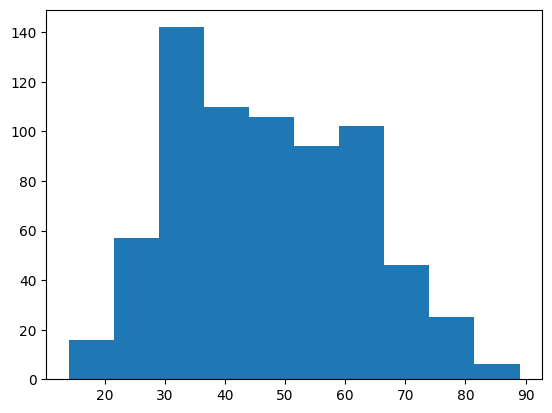

In [140]:
# some age values are missing (they are '--)
# we will drop them
float_idx = clinical_df_joined['age_at_index'].map(lambda x: x.isdigit()).values
data_valid_age = data.loc[float_idx]
clinical_df_valid_age = clinical_df_joined[float_idx]

age = clinical_df_valid_age['age_at_index'].astype(float)
plt.hist(age, bins=10)

In [145]:
K = 1000
def train_xgboost_model(data, target):
    # Ignore the first column "gene_id"
    # all_features = data.iloc[:, 1:]

    # perform feature selection
    test = SelectKBest(score_func=f_regression, k=K)
    features = test.fit_transform(data, target)


    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42)

    # Train an XGBoost regression model
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate the mean squared error
    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")

    return model

In [146]:
# print(data_valid_age.dtypes)
print(age.dtype)
model = train_xgboost_model(data_valid_age, age)

float64
Mean Squared Error: 113.77116193431137


(array([  4.,   0.,   0.,   2.,   2.,   1.,   4.,   3.,   0.,   3.,   6.,
          6., 638.,   5.,   7.,   6.,   5.,   2.,   5.,   1.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   1.,   0.,   1.]),
 array([-23.06995773, -21.27139715, -19.47283656, -17.67427597,
        -15.87571538, -14.0771548 , -12.27859421, -10.48003362,
         -8.68147303,  -6.88291245,  -5.08435186,  -3.28579127,
         -1.48723068,   0.31132991,   2.10989049,   3.90845108,
          5.70701167,   7.50557226,   9.30413284,  11.10269343,
         12.90125402,  14.69981461,  16.49837519,  18.29693578,
         20.09549637,  21.89405696,  23.69261754,  25.49117813,
         27.28973872,  29.08829931,  30.88685989]),
 <BarContainer object of 30 artists>)

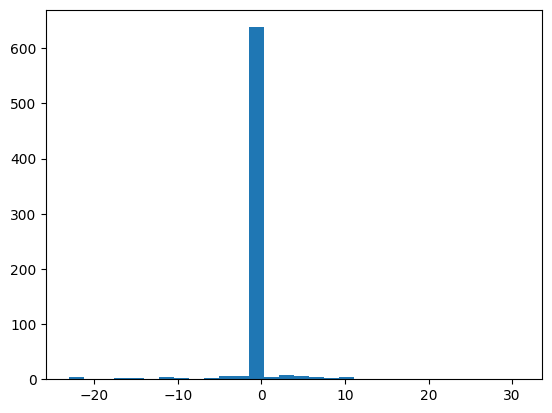

In [149]:
# perform feature selection
test = SelectKBest(score_func=f_regression, k=K)
features = test.fit_transform(data_valid_age, age)

predictions = model.predict(features)
results = pd.DataFrame({'Actual': age, 'Predicted': predictions})
errors = results['Actual'] - results['Predicted']
plt.hist(errors, bins=30)

In [150]:
results

,Actual,Predicted
case_id,,
3caf009f-d9e0-4c57-b1d9-8eb59fc833bd,78.0,77.999817
da5f6940-e8ee-4fd1-a8da-4cd68e02e59c,62.0,61.999722
a2ac9937-f351-4d78-9261-264bf6c21e0c,43.0,42.999821
521ea765-1bd1-423d-a75d-091243df37a9,53.0,52.999851
79a68b32-29a3-47bf-9b2b-643ec7323d73,64.0,64.000168
...,...,...
09552b53-4393-4811-a671-a9ef6eff4790,20.0,20.000271
cb041720-0efa-4eb6-a9a5-b6e138bb1a99,24.0,24.000219
f62be2b8-88c4-4a7e-8c80-8176fb5f6c56,36.0,36.000317
